## Video Game Recommendation System

The project's goal is to offer recommendations for video games by taking into account various factors such as the game's genre, platform, ratings, and both critic and user scores. This initiative will benefit individuals who are interested in discovering new games based on a particular title and platform <em>(optional)</em>, as well as businesses involved in the video games industry who seek to gain a deeper understanding of its trends and workings.

In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings("ignore")

### Importing and Transforming Dataset

The information used in the dataset was obtained from <a href="https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings">Video Game Sales with Ratings</a> in Kaggle, which were web scraped by Gregory Smith from VGChartz Video Games Sales. The collection of data includes details such as the game's title, genre, the platform it runs on, the company that published it, and other relevant information. From the year 1980 up to 2020, the dataset includes a wide range of video game releases that spans over four decades.

In [309]:
video_games_df = pd.read_csv("./Dataset/Video Games Sales.csv")

print(f"No. of records: {video_games_df.shape[0]}")
video_games_df.head(5)

No. of records: 16719


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


We removed certain features from the dataset as they are not significant for our recommendation system such as the release year, developer and the sales for each region.

In [310]:
video_games_filtered_df = video_games_df[['Name', 'Platform', 'Genre', 'Critic_Score', 'User_Score', 'Rating']]
video_games_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16717 non-null  object 
 1   Platform      16719 non-null  object 
 2   Genre         16717 non-null  object 
 3   Critic_Score  8137 non-null   float64
 4   User_Score    10015 non-null  object 
 5   Rating        9950 non-null   object 
dtypes: float64(1), object(5)
memory usage: 783.8+ KB


### Exploratory Data Analysis

Check the total number of missing values for each feature in the dataset 

In [311]:
video_games_filtered_df.isna().sum().sort_values(ascending=False)

Critic_Score    8582
Rating          6769
User_Score      6704
Name               2
Genre              2
Platform           0
dtype: int64

Remove the records with missing data in the `Name` and/or `Genre` features. Substitute the term `Unknown` for any missing information in the `Rating` field.

In [312]:
# Remove missing values
video_games_filtered_df.dropna(subset=['Name', 'Genre'], axis=0, inplace=True)
video_games_filtered_df = video_games_filtered_df.reset_index(drop=True)

# Value substitution
video_games_filtered_df.fillna({'Rating' : 'Unknown'}, inplace=True)

video_games_filtered_df[['Name', 'Genre', 'Rating']].isna().sum()

Name      0
Genre     0
Rating    0
dtype: int64

Examine the frequency of data types for each categorical feature: `Genre`, `Platform`, and `Rating`.

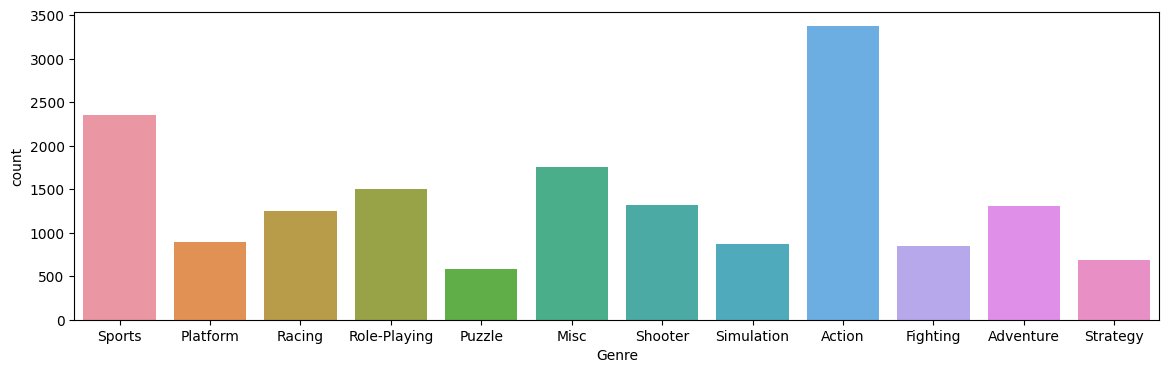

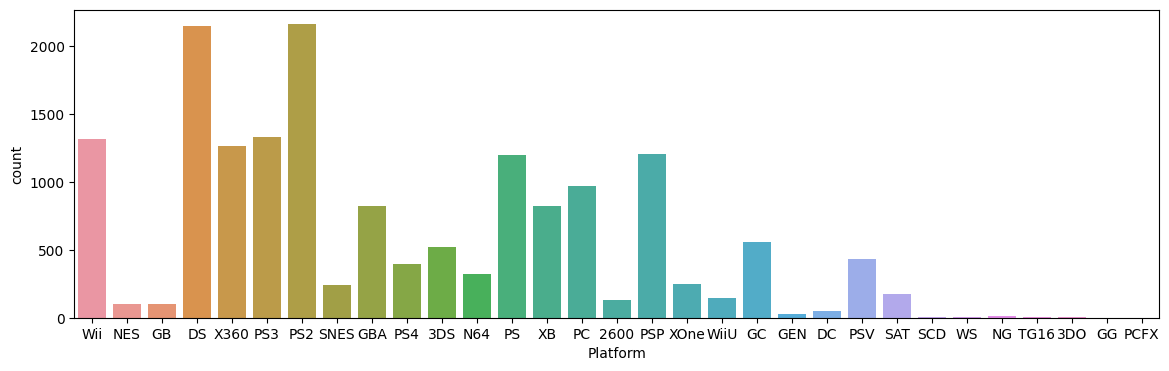

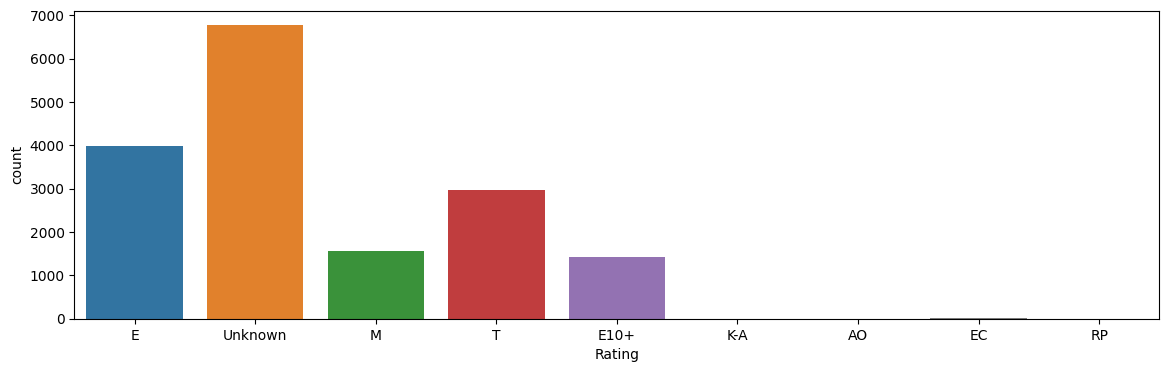

In [313]:
features = video_games_filtered_df[['Genre', 'Platform', 'Rating']].columns

for idx, feature in enumerate(features):
    plt.figure(figsize = (14,4))
    sns.countplot(data=video_games_filtered_df, x=feature)
plt.show()

From the charts above, we can say that:
- Several platforms like SCD, WS, and GG have a smaller collection of video games. Consequently, if a game is chosen from these platforms, the recommendations might include games from other platforms, while taking other features into account for distance calculation.
- Approximately half of all video games do not have a defined rating. Moreover, a small number of games fall into the categories of 'K-A', 'AO', 'EC', or 'RP'. 

We will only consider games with a specified rating. Hence, all 'Unknown' ratings will be removed from the dataset

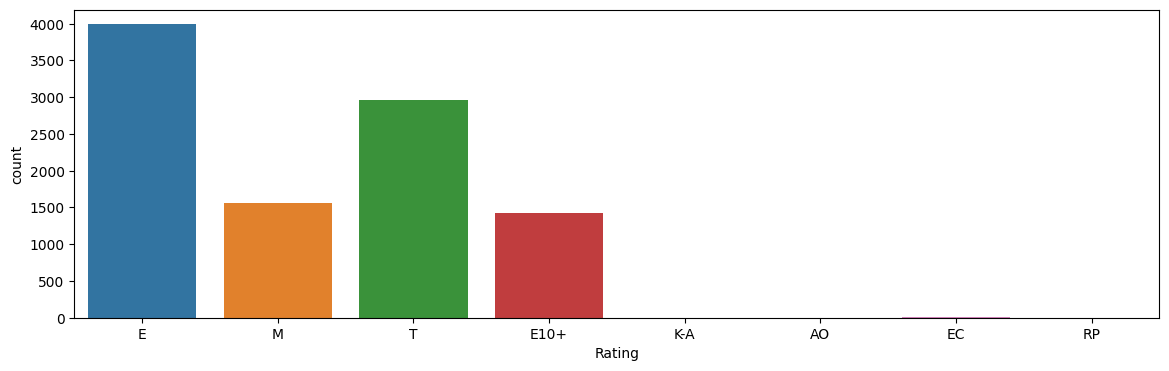

In [314]:
video_games_filtered_df = video_games_filtered_df.query("Rating != 'Unknown'")

plt.figure(figsize = (14,4))
sns.countplot(data=video_games_filtered_df, x='Rating')
plt.show()

Create additional features that correspond to the `User_Score` and `Critic_score` variables. Replace any missing or 'tbd' values with a specific substitute -- the substitute will be calculated as the mean value of the `User_Score` or `Critic_score` variable within a particular genre, e.g. the average of all scores under the 'Action' category.

In [315]:
# Replace 'tbd' value to NaN
video_games_filtered_df['User_Score'] = np.where(video_games_filtered_df['User_Score'] == 'tbd', np.nan, video_games_filtered_df['User_Score']).astype(float)

# Group the records by Genre, then aggregate them calculating the average of both Critic Score and User Score
video_game_score_mean = video_games_filtered_df[['Genre', 'Critic_Score', 'User_Score']].groupby('Genre', as_index=False).agg(Ave_Critic_Score = ('Critic_Score', 'mean'), 
                                                                                                                              Ave_User_Score = ('User_Score', 'mean'))

# Merge the average scores with the main dataframe
video_games_filtered_df = video_games_filtered_df.merge(video_game_score_mean, on='Genre')
video_games_filtered_df

,Name,Platform,Genre,Critic_Score,User_Score,Rating,Ave_Critic_Score,Ave_User_Score
0,Wii Sports,Wii,Sports,76.0,8.0,E,72.037257,6.973126
1,Wii Sports Resort,Wii,Sports,80.0,8.0,E,72.037257,6.973126
2,Wii Fit,Wii,Sports,80.0,7.7,E,72.037257,6.973126
3,Wii Fit Plus,Wii,Sports,80.0,7.4,E,72.037257,6.973126
4,FIFA 16,PS4,Sports,82.0,4.3,E,72.037257,6.973126
...,...,...,...,...,...,...,...,...
9945,The Eye of Judgment: Legends,PSP,Strategy,69.0,7.9,E10+,72.254296,7.320930
9946,Hospital Tycoon,PC,Strategy,51.0,3.8,E10+,72.254296,7.320930
9947,End of Nations,PC,Strategy,NaN,NaN,T,72.254296,7.320930
9948,Worms 2,PC,Strategy,NaN,8.1,K-A,72.254296,7.320930


In [316]:
video_games_filtered_df['Critic_Score_Imputed'] = np.where(video_games_filtered_df['Critic_Score'].isna(), video_games_filtered_df['Ave_Critic_Score'], video_games_filtered_df['Critic_Score'])
video_games_filtered_df['User_Score_Imputed'] = np.where(video_games_filtered_df['User_Score'].isna(),  video_games_filtered_df['Ave_User_Score'], video_games_filtered_df['User_Score'])
video_games_filtered_df

,Name,Platform,Genre,Critic_Score,User_Score,Rating,Ave_Critic_Score,Ave_User_Score,Critic_Score_Imputed,User_Score_Imputed
0,Wii Sports,Wii,Sports,76.0,8.0,E,72.037257,6.973126,76.000000,8.00000
1,Wii Sports Resort,Wii,Sports,80.0,8.0,E,72.037257,6.973126,80.000000,8.00000
2,Wii Fit,Wii,Sports,80.0,7.7,E,72.037257,6.973126,80.000000,7.70000
3,Wii Fit Plus,Wii,Sports,80.0,7.4,E,72.037257,6.973126,80.000000,7.40000
4,FIFA 16,PS4,Sports,82.0,4.3,E,72.037257,6.973126,82.000000,4.30000
...,...,...,...,...,...,...,...,...,...,...
9945,The Eye of Judgment: Legends,PSP,Strategy,69.0,7.9,E10+,72.254296,7.320930,69.000000,7.90000
9946,Hospital Tycoon,PC,Strategy,51.0,3.8,E10+,72.254296,7.320930,51.000000,3.80000
9947,End of Nations,PC,Strategy,NaN,NaN,T,72.254296,7.320930,72.254296,7.32093
9948,Worms 2,PC,Strategy,NaN,8.1,K-A,72.254296,7.320930,72.254296,8.10000


Compare and analyze the summary statistics of `User_Score` and `Critic_Score` and their new features (`User_Score_Imputed` and `Critic_Score_Imputed`) by imputing missing values. The results indicate that filling in missing values did not significantly affect the average of the data. There was a decrease of about 4 in the standard deviation of the critic score, which was expected, and a slight difference in the user score.

In [317]:
video_games_filtered_df[['Critic_Score', 'Critic_Score_Imputed', 'User_Score', 'User_Score_Imputed']].describe()

,Critic_Score,Critic_Score_Imputed,User_Score,User_Score_Imputed
count,8054.000000,9950.000000,7504.000000,9950.000000
mean,68.971319,68.851751,7.126879,7.107768
std,13.951640,12.594336,1.500750,1.305869
min,13.000000,13.000000,0.000000,0.000000
25%,60.000000,63.000000,6.400000,6.800000
50%,71.000000,69.000000,7.500000,7.136686
75%,79.000000,77.000000,8.200000,8.000000
max,98.000000,98.000000,9.700000,9.700000


Drop all the fields related to critic and user scores except for the new ones with imputed missing values.

In [318]:
video_games_final_df = video_games_filtered_df.drop(columns=['User_Score', 'Critic_Score', 'Ave_Critic_Score', 'Ave_User_Score'], axis=1)
video_games_final_df = video_games_final_df.reset_index(drop=True)

video_games_final_df = video_games_final_df.rename(columns={'Critic_Score_Imputed':'Critic_Score', 'User_Score_Imputed':'User_Score'})
video_games_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9950 entries, 0 to 9949
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          9950 non-null   object 
 1   Platform      9950 non-null   object 
 2   Genre         9950 non-null   object 
 3   Rating        9950 non-null   object 
 4   Critic_Score  9950 non-null   float64
 5   User_Score    9950 non-null   float64
dtypes: float64(2), object(4)
memory usage: 466.5+ KB


Analyze the data distribution for `Critic_Score` and `User_Score`, and assess the correlation between these two features. From the charts below, we can conclude that the critic of the video games tend to give lower scores than the actual users.

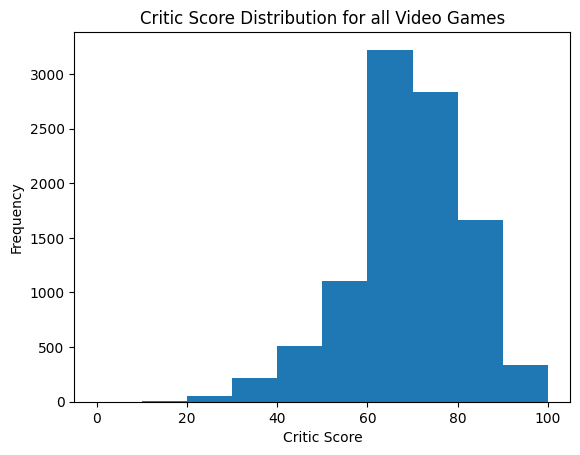

In [319]:
hist, bins = np.histogram(video_games_final_df['Critic_Score'], bins=10, range=(0, 100))

plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]), align='edge')
plt.xlabel('Critic Score')
plt.ylabel('Frequency')
plt.title("Critic Score Distribution for all Video Games")
plt.show()

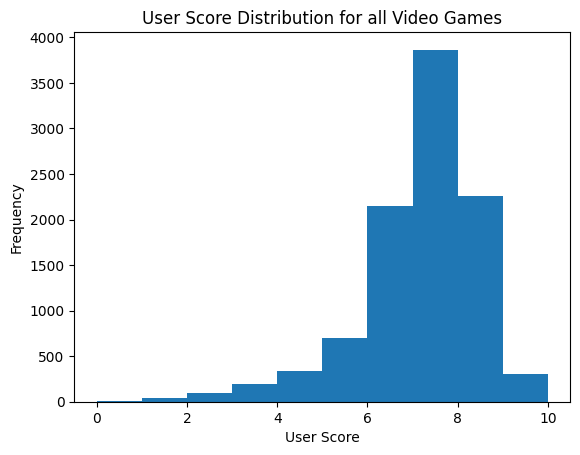

In [320]:
hist, bins = np.histogram(video_games_final_df['User_Score'], bins=10, range=(0, 10))

plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]), align='edge')
plt.xlabel('User Score')
plt.ylabel('Frequency')
plt.title("User Score Distribution for all Video Games")
plt.show()

[Text(0.5, 0, 'User Score'),
 Text(0, 0.5, 'Critic Score'),
 Text(0.5, 1.0, 'User Scores vs. Critic Scores')]

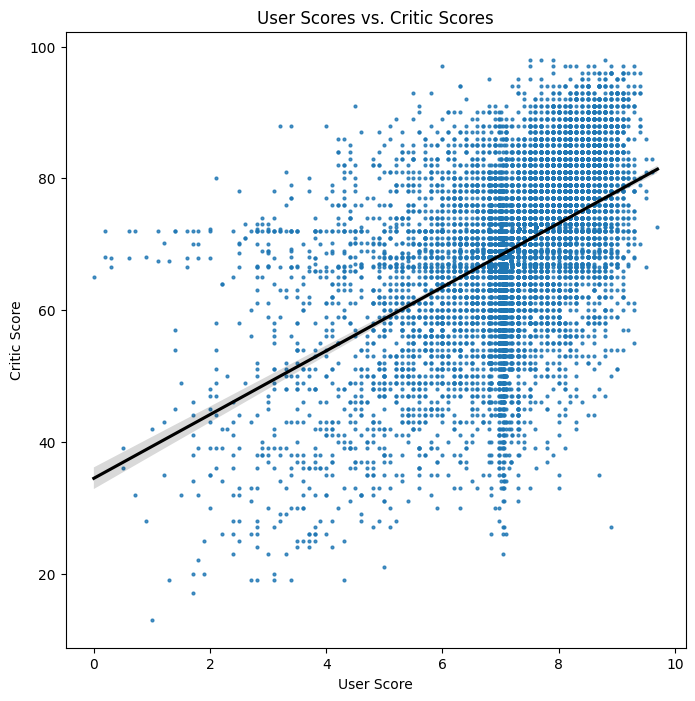

In [321]:
plt.figure(figsize=(8, 8))
ax = sns.regplot(x=video_games_final_df['User_Score'], y=video_games_final_df['Critic_Score'], line_kws={"color": "black"}, scatter_kws={'s': 4})
ax.set(xlabel ="User Score", ylabel = "Critic Score", title="User Scores vs. Critic Scores")

Perform a last verification of the dataframe details prior to transforming the categorical attributes into dummary indicators.

In [322]:
video_games_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9950 entries, 0 to 9949
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          9950 non-null   object 
 1   Platform      9950 non-null   object 
 2   Genre         9950 non-null   object 
 3   Rating        9950 non-null   object 
 4   Critic_Score  9950 non-null   float64
 5   User_Score    9950 non-null   float64
dtypes: float64(2), object(4)
memory usage: 466.5+ KB


### Converting Categorical Features to Dummy Indicators

Get all categorical features, exluding name of the game

In [323]:
categorical_columns = [name for name in video_games_final_df.columns if video_games_final_df[name].dtype=='O']
categorical_columns = categorical_columns[1:]

print(f'There are {len(categorical_columns)} categorical features:\n')
print(", ".join(categorical_columns))

There are 3 categorical features:

Platform, Genre, Rating


Transform all categorical attributes into binary dummy variables where the value is 0 (representing No) or 1 (representing Yes).

In [324]:
video_games_df_dummy = pd.get_dummies(data=video_games_final_df, columns=categorical_columns)
video_games_df_dummy.head(5)

,Name,Critic_Score,User_Score,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,...,Genre_Sports,Genre_Strategy,Rating_AO,Rating_E,Rating_E10+,Rating_EC,Rating_K-A,Rating_M,Rating_RP,Rating_T
0,Wii Sports,76.0,8.0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,Wii Sports Resort,80.0,8.0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,Wii Fit,80.0,7.7,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
3,Wii Fit Plus,80.0,7.4,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,FIFA 16,82.0,4.3,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


After the conversion, the variables have expanded from the original 6 columns to a total of 40 columns.

In [325]:
video_games_df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9950 entries, 0 to 9949
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                9950 non-null   object 
 1   Critic_Score        9950 non-null   float64
 2   User_Score          9950 non-null   float64
 3   Platform_3DS        9950 non-null   uint8  
 4   Platform_DC         9950 non-null   uint8  
 5   Platform_DS         9950 non-null   uint8  
 6   Platform_GBA        9950 non-null   uint8  
 7   Platform_GC         9950 non-null   uint8  
 8   Platform_PC         9950 non-null   uint8  
 9   Platform_PS         9950 non-null   uint8  
 10  Platform_PS2        9950 non-null   uint8  
 11  Platform_PS3        9950 non-null   uint8  
 12  Platform_PS4        9950 non-null   uint8  
 13  Platform_PSP        9950 non-null   uint8  
 14  Platform_PSV        9950 non-null   uint8  
 15  Platform_Wii        9950 non-null   uint8  
 16  Platfo

### Standardizing the Numerical Features

Transform numerical data to a standardized form by scaling them to have a mean of 0 and a standard deviation of 1. The purpose of standardization is to ensure that all features are on a similar scale and have equal importance in determining the output variable.

In [326]:
features = video_games_df_dummy.drop(columns=['Name'], axis=1)

scale = StandardScaler()
scaled_features = scale.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features, columns=features.columns)

scaled_features.head(5)

,Critic_Score,User_Score,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,Platform_PS2,...,Genre_Sports,Genre_Strategy,Rating_AO,Rating_E,Rating_E10+,Rating_EC,Rating_K-A,Rating_M,Rating_RP,Rating_T
0,0.567605,0.683282,-0.15314,-0.037537,-0.3832,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,2.365115,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
1,0.885224,0.683282,-0.15314,-0.037537,-0.3832,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,2.365115,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
2,0.885224,0.453538,-0.15314,-0.037537,-0.3832,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,2.365115,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
3,0.885224,0.223794,-0.15314,-0.037537,-0.3832,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,2.365115,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
4,1.044034,-2.150224,-0.15314,-0.037537,-0.3832,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,2.365115,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896


### Creating a Model

We will utilize `NearestNeighbors`, a machine learning algorithm that belongs to the category of unsupervised learning algorithms that is used for finding the k-nearest neighbors of a data point or a set of data points in a given dataset. The model will use 'cosine' to calculate the distance between records and find the 11 similar items to user input. 

In [327]:
model = NearestNeighbors(n_neighbors=11, metric='cosine', algorithm='brute').fit(scaled_features)
print(model)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=11)


The model will create a list of 11 index values of games that are similar to the user input, which will include the input itself. Additionally, it will calculate the distances between these games. A distance of zero (0) indicates that the input was compared with the same game; hence, it will be excluded from the recommendation once we test the model.

In [328]:
vg_distances, vg_indices = model.kneighbors(scaled_features)

print("List of indexes and distances for each game:\n")
print(vg_indices[:5], "\n")
print(vg_distances[:5])

List of indexes and distances for each game:

[[   0  544  655  168    1  615  482    2  259  556  164]
 [   1  482  168    2  259    0  544  468  181  702  441]
 [   2    1    3  482  168    0  275  544  324  259  441]
 [   3  275    2  324  190    1  482  168    0  261  199]
 [   4  103    5  250    9 1316   37   83   40  147   97]] 

[[0.         0.00014572 0.00079596 0.00152363 0.0024842  0.00276265
  0.00385591 0.0039004  0.00456854 0.00476779 0.00488366]
 [0.         0.0001504  0.00030433 0.00130701 0.00223695 0.0024842
  0.00265393 0.00271666 0.00338307 0.00338307 0.00343195]
 [0.         0.00130701 0.00133485 0.00142953 0.00250431 0.0039004
  0.00433879 0.00494234 0.00512249 0.00695777 0.00715692]
 [0.         0.00121304 0.00133485 0.00201414 0.00273153 0.00528007
  0.00537409 0.00737663 0.00797692 0.0079935  0.00802116]
 [0.         0.00186154 0.00315705 0.00792415 0.01052332 0.01378495
  0.01394963 0.01768446 0.02359152 0.0273218  0.03418885]]


`TfidfVectorizer` is a feature extraction method commonly used in natural language processing and information retrieval tasks. In this case, it is used to suggest a video game title based on the user input (i.e. game that doesn't exist in the records) by evaluating the importance of words in the input relative to the existing records.

In [329]:
game_names = video_games_df_dummy['Name'].drop_duplicates()
game_names = game_names.reset_index(drop=True)

vectorizer = TfidfVectorizer(use_idf=True)
vectorizer.fit(game_names)
print(vectorizer)

TfidfVectorizer()


In [330]:
game_title_vectors = vectorizer.transform(game_names)
game_title_vectors

<6067x4822 sparse matrix of type '<class 'numpy.float64'>'
	with 20518 stored elements in Compressed Sparse Row format>

### Testing the Model

Here is a program that utilizes the above-mentioned model to provide video game recommendations to users. It will ask the user to enter the game's name and, optionally, the platform to filter the results. The list of recommended games will be arranged based on the calculated distances. On the other hand, if the game's name in not in the record, the program will suggest a new game that has the closest match to the input.

In [331]:
def VideoGameTitleRecommender(video_game_name):
    '''
    This function will recommend a game title that has the closest match to the input
    '''
    query_vector = vectorizer.transform([video_game_name])
    similarity_scores = cosine_similarity(query_vector, game_title_vectors)

    closest_match_index = similarity_scores.argmax()
    closest_match_game_name = game_names[closest_match_index]

    return closest_match_game_name


def VideoGameRecommender(video_game_name, video_game_platform='Any'):
    '''
    This function will provide game recommendations based on various features of the game
    '''
    default_platform = 'Any'

    # User input: Game Title and Platform
    if video_game_platform != default_platform:
        video_game_idx = video_games_final_df.query("Name == @video_game_name & Platform == @video_game_platform").index
        
        if video_game_idx.empty:
            video_game_idx = video_games_final_df.query("Name == @video_game_name").index

            if not video_game_idx.empty:
                print(f"Note: The game is not available on the specified platform. The recommendations will be based on the game's title.\n")
                video_game_platform = default_platform
    
    # User input: Game Title only
    else:
        video_game_idx = video_games_final_df.query("Name == @video_game_name").index  
    
    if video_game_idx.empty:
        # If the game entered by the user doesn't exist in the records, the program will recommend a new game similar to the input
        closest_match_game_name = VideoGameTitleRecommender(video_game_name)

        print(f"'{video_game_name}' doesn't exist in the records.\n")
        print(f"You may want to try '{closest_match_game_name}', which is the closest match to the input.")
        return None
    
    else :
        recommended_idx = vg_indices[video_game_idx[0]]

        # User input: Game Title only
        if video_game_platform == default_platform:

            # Place in a separate dataframe the indices and distances, then sort the record by distance in ascending order       
            vg_combined_dist_idx_df = pd.DataFrame()
            for idx in video_game_idx:
                vg_dist_idx_df = pd.concat([pd.DataFrame(vg_indices[idx]), pd.DataFrame(vg_distances[idx])], axis=1)
                vg_combined_dist_idx_df = pd.concat([vg_combined_dist_idx_df, vg_dist_idx_df])

            vg_combined_dist_idx_df = vg_combined_dist_idx_df.set_axis(['Index', 'Distance'], axis=1, inplace=False).reset_index(drop=True)
            vg_combined_dist_idx_df = vg_combined_dist_idx_df.sort_values(by='Distance', ascending=True)

            video_game_list = video_games_final_df.iloc[vg_combined_dist_idx_df['Index']]

            # Remove any duplicate game names to provide the user with a diverse selection of recommended games
            video_game_list = video_game_list.drop_duplicates(subset=['Name'], keep='first')

            # Remove from the list any game that shares the same name as the input
            video_game_list = video_game_list.query('Name != @video_game_name')
            
            # Get the first 10 games in the list
            video_game_list = video_game_list.head(10)

        # User input: Game Title and Platform
        else:
            video_game_list = video_games_final_df.iloc[recommended_idx]
            
            # Remove from the list any game that shares the same name as the input
            video_game_list = video_game_list.query('Name != @video_game_name')

        print(f"Top 10 Recommended Video Games for '{video_game_name}' [platform:{video_game_platform}]")

        display(video_game_list.style.hide_index())

__Test data #1__

The user has provided only the game title as input. Therefore, regardless of the platform, the program will only display the top 10 games that are similar to the user's input input in relation to the computed distance.

In [332]:
VideoGameRecommender('Call of Duty: World at War')

Top 10 Recommended Video Games for 'Call of Duty: World at War' [platform:Any]


Name,Platform,Genre,Rating,Critic_Score,User_Score
Bulletstorm,X360,Shooter,M,84.000000,7.600000
Halo: Combat Evolved,PC,Shooter,M,83.000000,7.400000
Red Faction: Guerrilla,PC,Shooter,M,82.000000,7.500000
Battlefield 3,PS3,Shooter,M,85.000000,7.500000
Tom Clancy's Rainbow Six: Vegas,PS3,Shooter,M,86.000000,7.600000
Unreal Tournament III,PS3,Shooter,M,86.000000,7.700000
Quake 4,PC,Shooter,M,81.000000,7.600000
Max Payne 3,PS3,Shooter,M,87.000000,7.800000
Resistance 3,PS3,Shooter,M,83.000000,7.800000
Tom Clancy's Rainbow Six: Vegas 2,X360,Shooter,M,82.000000,7.800000


__Test data #2__

The user has provided the game title and the platform as input. So, only the top 10 games that match the game title and platform entered by the user will be displayed.

NOTE: If a platform has fewer video games available, the program may suggest games from other platforms based on various factors when calculating similarity.

In [333]:
VideoGameRecommender('Call of Duty: World at War', 'PC')

Top 10 Recommended Video Games for 'Call of Duty: World at War' [platform:PC]


Name,Platform,Genre,Rating,Critic_Score,User_Score
Halo: Combat Evolved,PC,Shooter,M,83.000000,7.400000
Red Faction: Guerrilla,PC,Shooter,M,82.000000,7.500000
Bulletstorm,PC,Shooter,M,82.000000,7.700000
Quake 4,PC,Shooter,M,81.000000,7.600000
Borderlands,PC,Shooter,M,81.000000,7.800000
Crysis: Warhead,PC,Shooter,M,84.000000,7.900000
Max Payne 3,PC,Shooter,M,87.000000,7.600000
Doom 3,PC,Shooter,M,87.000000,7.600000
Gears of War,PC,Shooter,M,87.000000,7.800000
Unreal Tournament III,PC,Shooter,M,83.000000,8.000000


__Test data #3__

The user has provided the game title and the platform as input. However, the game is not available on the specified platform. Given this scenario, recommendations will solely be based on the game title.

In [334]:
VideoGameRecommender('Call of Duty: World at War', 'XB')

Note: The game is not available on the specified platform. The recommendations will be based on the game's title.

Top 10 Recommended Video Games for 'Call of Duty: World at War' [platform:Any]


Name,Platform,Genre,Rating,Critic_Score,User_Score
Bulletstorm,X360,Shooter,M,84.000000,7.600000
Halo: Combat Evolved,PC,Shooter,M,83.000000,7.400000
Red Faction: Guerrilla,PC,Shooter,M,82.000000,7.500000
Battlefield 3,PS3,Shooter,M,85.000000,7.500000
Tom Clancy's Rainbow Six: Vegas,PS3,Shooter,M,86.000000,7.600000
Unreal Tournament III,PS3,Shooter,M,86.000000,7.700000
Quake 4,PC,Shooter,M,81.000000,7.600000
Max Payne 3,PS3,Shooter,M,87.000000,7.800000
Resistance 3,PS3,Shooter,M,83.000000,7.800000
Tom Clancy's Rainbow Six: Vegas 2,X360,Shooter,M,82.000000,7.800000


__Test data #4__

if the user has provided game title that does not exist in the records, then no recommendations will be shown. However, the program will provide user with the name of a game that has closest match to the input title.

In [335]:
VideoGameRecommender('Call of Duty', 'Wii')

'Call of Duty' doesn't exist in the records.

You may want to try 'Call of Duty 3', which is the closest match to the input.


### Assumptions
- Removed records with missing/unknown values in `Rating` feature
- Conducted data-imputation on missing and 'tbd' values in `User_Score` and `Critic_Score` features. The imputed data was calculated as the mean value of the `User_Score` or `Critic_score` variable within a particular genre, e.g. the average of all scores under the 'Action' category.

### References

1. https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings
2. https://thecleverprogrammer.com/2021/01/17/book-recommendation-system/
3. https://aman-makwana101932.medium.com/understanding-recommendation-system-and-knn-with-project-book-recommendation-system-c648e47ff4f6